Modelo baseado no exemplo segmentação de imagem: https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/pt-br/tutorials/images/segmentation.ipynb#scrollTo=FD60EbcAQqov

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [1]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

import os
import numpy as np
from osgeo import gdal

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_BANDS = 4
images_path = 'Data/BuildingsDataSet/Images/'
masks_path = 'Data/BuildingsDataSet/Masks/'

In [3]:
def load_image(image):
    return gdal.Open(image, gdal.GA_ReadOnly)
    
def convert_to_array(dataset):
    bands = [dataset.GetRasterBand(i + 1).ReadAsArray() for i in range(dataset.RasterCount)]
    return np.stack(bands, 2)

In [ ]:
files = next(os.walk(images_path))[2]

all_images = []
all_masks = []
num_skipped = 0
for image_file in files:

    image_path = images_path + image_file
    image = load_image(image_path)
    image_data = convert_to_array(image)
    image_data[np.isnan(image_data)] = 999 # adiciona 0 onde é NaN

    mask_path = masks_path + image_file
    mask = load_image(mask_path)
    mask_data = convert_to_array(mask)
    #mask_data[np.isnan(mask_data)] = 0 # adiciona 0 onde é NaN
    mask_data[mask_data>0] = 1
    mask_data[mask_data<=0] = 0
    
    # Pule qualquer imagem que esteja mais de 99% vazia.
    if np.any(mask_data):
        num_white_pixels = len(mask_data[mask_data==1])
        num_black_pixels = len(mask_data[mask_data==0])
        if num_black_pixels == 0: num_black_pixels = 1 # para evitar erro de dividir por 0

        if num_white_pixels/num_black_pixels < 0.01:
            num_skipped+=1
            continue
        
        all_images.append(image_data)
        all_masks.append(mask_data)
    
    #if len(all_images) > 2:
        #break

images = np.array(all_images)
masks = np.array(all_masks, dtype=int)
print('Total imagens: \n', len(all_images))
print('Images: \n', images.shape)
print('Masks: \n', masks.shape)
print("\n{} Images were skipped.".format(num_skipped))
print("\nUnique elements in the train mask:", np.unique(masks))

In [244]:
TRAIN_LENGTH = 500 #info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
seed = 56

In [ ]:
from sklearn.model_selection import train_test_split
train_images, test_images, train_masks, test_masks = train_test_split(images, masks, test_size=0.2, random_state=seed)
del images, masks
print("TRAIN SET")
print(train_images.shape)
print(train_masks.shape)
print("TEST SET")
print(test_images.shape)
print(test_masks.shape)

In [247]:
@tf.function
def load_image_train(images, masks):
    image = tf.image.resize(images, (128, 128))
    mask = tf.image.resize(masks, (128, 128))
    
    return tf.data.Dataset.from_tensor_slices((image, mask))

In [248]:
train = load_image_train(train_images, train_masks)
test = load_image_train(test_images, test_masks)

In [250]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [251]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        #print(display_list[i][:,:,[1,2,1]])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
#sample_image, sample_mask = train_images[2], train_masks[2]
#display([sample_image, sample_mask])

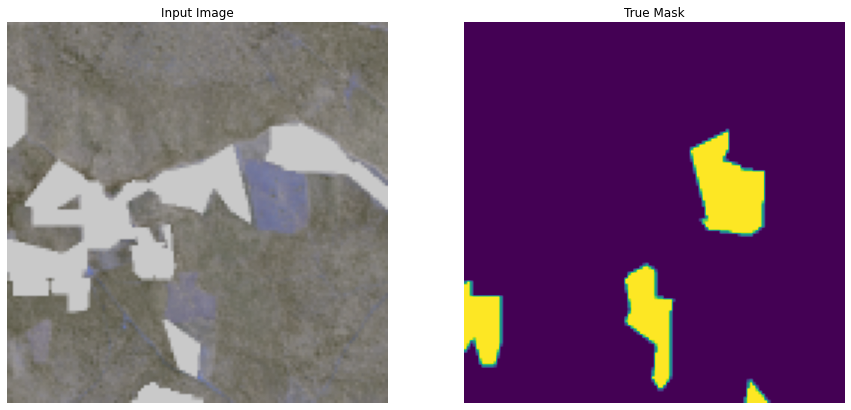

In [252]:
for image, mask in train.take(33):
    sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [253]:
OUTPUT_CHANNELS = 2

In [264]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use as ativações dessas camadas
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Crie o modelo de extração de características
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

In [257]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [258]:
def unet_model(output_channels):
    # Esta é a última camada do modelo
    last = tf.keras.layers.Conv2DTranspose(
        output_channels, 3, strides=2,
        padding='same', activation='softmax')  #64x64 -> 128x128

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling através do modelo
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

    # Upsampling e estabelecimento das conexões de salto
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [259]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
#tf.keras.utils.plot_model(model, show_shapes=True)

In [260]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [261]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in test.take(num):
            pred_mask = model.predict(image[tf.newaxis, ...])
            display([image, mask, create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

In [158]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

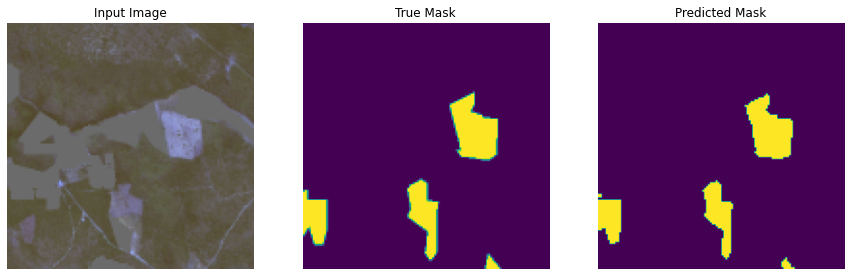


Sample Prediction after epoch 5

7/7 [==============================] - 18s 3s/step - loss: 0.0020 - accuracy: 0.9939 - val_loss: 0.2348 - val_accuracy: 0.9619


In [237]:
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 100 #info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

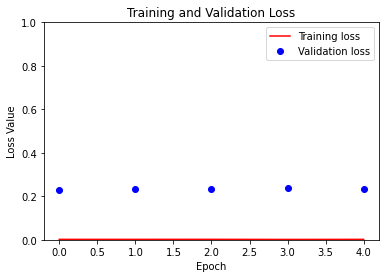

In [238]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

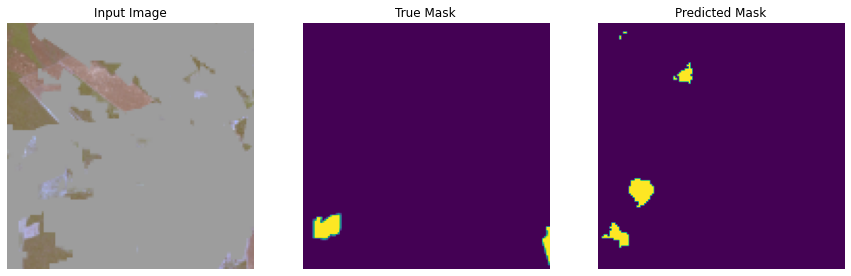

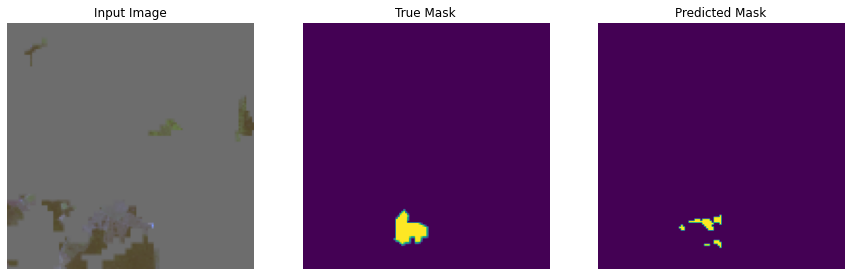

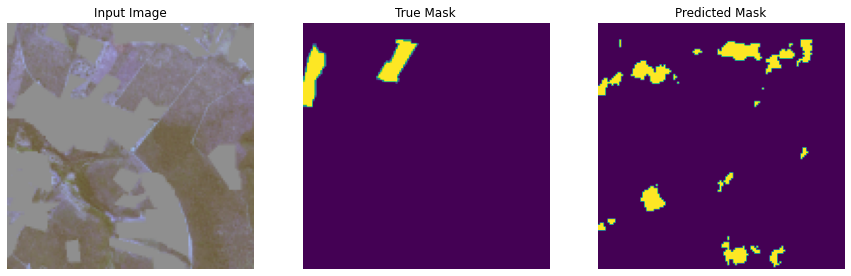

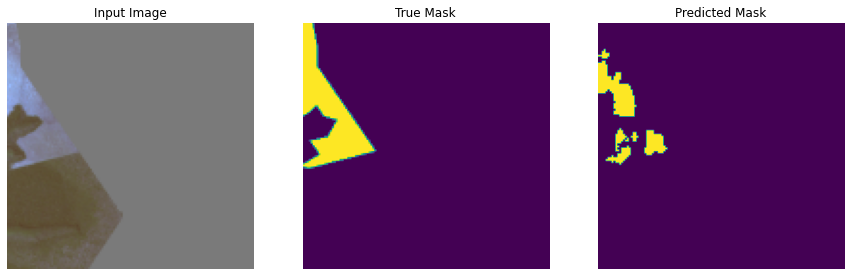

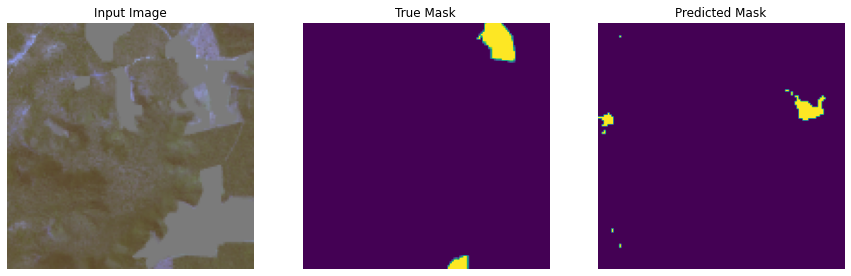

In [239]:
show_predictions(test_dataset, 5)